# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

My implementation:
- `agents/`: Folder containing reinforcement learning agents.
    - `ddpg.py`: **My DDPG agent is developed here**.
    - `actor_critic.py`: **My actor and critic neural network models are developed here**.
    - `plot_utils.py`: My utility functions for plotting the results.
- `task.py`: ** My task is developed here**. 

# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

from agents.ddpg import ddpg_agent
from agents.plot_utils import *
from task import Task, distance_reward, time_reward

Using TensorFlow backend.


## Instructions

Take a look at the files in the directory to better understand the structure of the project. 
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task. You will also design a reinforcement learning agent of you choice to complete the task.  

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

When specifying a task, you will derive the environment **state** from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose`: the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles ($\phi, \theta, \psi$),
- `task.sim.v`: the velocity of the quadcopter in ($x,y,z$) dimensions, and
- `task.sim.angular_v`: radians/second for each of the three Euler angles.

In the sample task in `task.py`, we use the **6-dimensional pose** of the quadcopter to construct the **state** of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to **expand the size of the state** vector by including the velocity information.  You can use **any combination of the pose, velocity, and angular velocity** - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation **`action_repeats`** timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a **4-dimensional action space**, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The **`reset()`** method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The **`step()`** method is perhaps the most important.  It accepts the agent's choice of **action `rotor_speeds`**, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from **`get_reward()`**.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## Define the Task, Design the Agent, and Train Your Agent!

Amend **`task.py`** to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, define your own agent in **`agents/`**. 

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to **tweak** various **hyperparameters** and the **reward function** for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

# main
## args

In [2]:
args = {
    "random_seed": 1234,
    ## task
    "runtime": 5.,                         # time limit (s) of the episode
    "init_pose": [0., 0., 10., 0., 0., 0.],  # initial [x, y, z]
    "target_pos": [0, 0., 80.],
    "obs": 'pos_v',               # 'pos' - position, 'pos_v' - position and velocity
    ## episodes
    "max_episodes": 100,          # 100, number of episodes
    "max_explore_episodes": 80,   # 80, number of episodes to decrease noise to 0 
    "max_episode_len": 5*50,      # time steps per episode, max_t = time (s) * 50 Hz 
    ## actor Neural Net
    "actor_h1": 32,      # 400
    "actor_h2": 64,      # 300
    "actor_lr": 1e-4,    # 1e-4
    ## critic Neural Net
    "critic_h1": 32,     # 400
    "critic_h2": 64,     # 300
    "critic_lr": 1e-3,   # 1e-3
    ## update rate, discount rate
    "tau": 1e-1,         # 1e-3
    "gamma": 0.99,       # 0.99
    ## OU Noise
    "ou_mu": 0.,
    "ou_theta": 0.15,    # 0.15
    "ou_sigma": 0.2,     # 0.2
    "ou_dt": 1,          # 1
    ## replay buffer
    "buffer_size": int(1e5),    # int(1e6)
    "minibatch_size": 64,       # 64
    ## tensorboard logs
    "summary_dir": './results/ddpg',  
}

assert(args['runtime'] * 50 == args['max_episode_len']) # check consistense

## Train DDPG agent

In [3]:
sess = tf.InteractiveSession()
tf.set_random_seed(int(args['random_seed']))

# initialize numpy seed
np.random.seed(int(args['random_seed']))

# initialize task (env)
runtime = args['runtime']                        # time limit of the episode
init_pose = np.array(args['init_pose'])          # initial pose, shape (6,)
init_velocities = np.array([0., 0., 0.])         # initial velocities, shape (3,)
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities, shape (3,)
target_pos = np.asarray(args['target_pos'])
obs = args['obs']
task = Task(obs, init_pose, init_velocities, init_angle_velocities, runtime, target_pos)

# train DDPG agent
agent = ddpg_agent(sess, task, args)
results, labels = agent.train(sess, task, args)

episode: 0, steps: 59, reward: 62.77
episode: 10, steps: 50, reward: 366.93
episode: 20, steps: 50, reward: 366.86
episode: 30, steps: 50, reward: 366.94
episode: 40, steps: 50, reward: 366.88
episode: 50, steps: 50, reward: 366.97
episode: 60, steps: 50, reward: 366.97
episode: 70, steps: 50, reward: 366.99
episode: 80, steps: 50, reward: 367.01
episode: 90, steps: 50, reward: 367.01


## Test the agent
test the the trained DDPG agent (run one episode)

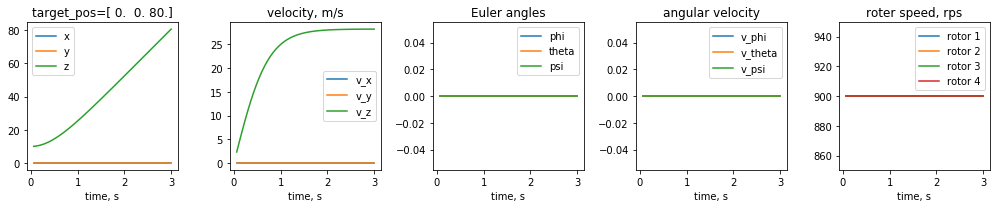

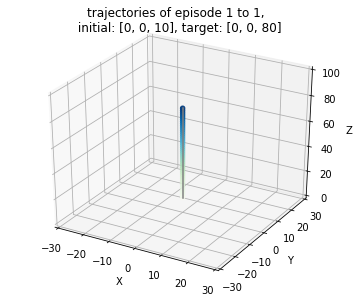

In [4]:
results_test, pos_all_test = agent.test(task, max_t=1000)
plot_test_results(task, results_test)
plot_trajectory(task, [0], pos_all_test, xmax=30, ymax=30, zmin=0, zmax=100)

# Reflections

## Question 1: task
Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

I specified a "takeoff" task. The goal is to go up to a target height as quickly as possible. For training the agent I set the target position assuming that: 1) the target z is higher than the initial z, and 2) the target x, y are the same as the initial x, y.
  
My **reward function** is defined as the product of a distance based reward and a time based reward,
$$R = R_{distance}(d) * R_{time}(t) $$
where $d$ denotes the Euclidean distance between the agent's position and the target position, and $t$ denotes the time spent so far by the agent in an episode.

### distance based reward
My distance based reward is defined as
$$R_{distance}(d) = 1 - \Big(\frac{d}{d_\max}\Big)^{0.4}$$
Here I set $d_\max=\sqrt{3*300^2} \approx 520$ m, based on the environment bounds of 300 m specified in the simulator `PhysicsSim`. I shape the distance reward such that
- reward stays positive within the working area => encourage the agent to keep trying
- reward $\leq 1$ => good for numerical stability
- reward's slope is smooth and gets sharper when approaching the target => give the agent gradual feedback

As shown in the figure below, the distance based reward decreases from 1 to 0 within $\approx$ 520 meters.

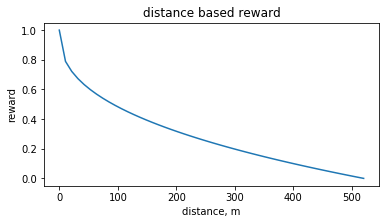

In [5]:
plt.figure(figsize=(6, 3))
dmax = 520; x_all = np.linspace(0, dmax, 50); r_all = [distance_reward(x, dmax) for x in x_all]
plt.plot(x_all, r_all); 
plt.title("distance based reward"); plt.ylabel("reward"); plt.xlabel("distance, m"); plt.show()

### time based reward
My time based reward is defined as 
$$R_{time}(t) = 1 - \frac{t}{t_\max}$$
Here I set $t_\max=5$ s, according to the maximum runtime of an episode. I shape the time reward to encourage the agent to reach the target as quickly as possible. As shown in the figure below, the time based reward decreases linearly from 1 to 0 within 5 seconds.

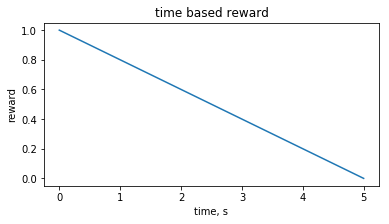

In [6]:
plt.figure(figsize=(6, 3))
tmax = 5; x_all = np.linspace(0, tmax, 50); r_all = [time_reward(x, tmax) for x in x_all]
plt.plot(x_all, r_all); 
plt.title("time based reward"); plt.ylabel("reward"); plt.xlabel("time, s"); plt.show()

### success reward and condition
I define the success condition of my "takeoff" task as $|\Delta z| < 1$, where $\Delta z$ is the height difference between the agent and the target. The task is successful if the agent's height is within 1 meter of the target height. When successful, 
- I end the episode because there is nothing further for the agent to learn, and
- I give the agent an additional big reward of 100, so that it won't keep whirling around the target for collecting small positive rewards.

## Question 2: agent
Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- I selected deep deterministic policy gradient (DDPG) method. It learns a deterministic policy to produce continuous-valued actions, which fits our quadcopter problem well. Deep Q-learning is also a popular and successful method in recent RL framework, but it is limited to discrete-valued actions so I didn't choose it.
- My hyper-parameters:
  - $\gamma$: 0.99
  - actor learning rate: 1e-4
  - critic learning rate: 1e-3
  - $\tau$: 0.1
  - For a complete list of parameters, please see below 

In [7]:
display(args)

{'random_seed': 1234,
 'runtime': 5.0,
 'init_pose': [0.0, 0.0, 10.0, 0.0, 0.0, 0.0],
 'target_pos': [0, 0.0, 80.0],
 'obs': 'pos_v',
 'max_episodes': 100,
 'max_explore_episodes': 80,
 'max_episode_len': 250,
 'actor_h1': 32,
 'actor_h2': 64,
 'actor_lr': 0.0001,
 'critic_h1': 32,
 'critic_h2': 64,
 'critic_lr': 0.001,
 'tau': 0.1,
 'gamma': 0.99,
 'ou_mu': 0.0,
 'ou_theta': 0.15,
 'ou_sigma': 0.2,
 'ou_dt': 1,
 'buffer_size': 100000,
 'minibatch_size': 64,
 'summary_dir': './results/ddpg'}

For the neural network architecture I used, please see the graph below generated by tensorboard.

**The actor neural network**: 
 - layer1: dense 32, relu activation
 - layer2: dense 64, relu activation
 - layer3: dense 4, sigmoid activation
 - last layer: scale the output to [0, 900], i.e., the expected range of roter speed
<img src = "assets/actor_model.png" style="width:50%;height:40%;"> 

**The critic neural network**: 
 - layer1: dense 32, relu activation
 - layer `Concatenate`: concatenate output from layer1 and action input
 - layer2: dense 64, relu activation
 - layer3: dense 1, no activation
<img src = "assets/critic_model.png" style="width:50%;height:40%;"> 

## Question 3: performance
Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: 
- The "takeoff" is an easy task. 
- My DDPG agent learns to ascend in the first 10 episodes, learns to go straight up to the target height in the first 20 episodes, and gets stabilized to follow the vertical trajectory after 20 episodes. I plot below the rewards and the trajectories during DDPG training
- Over the last 10 episodes the mean reward is 367.

## plot training results: rewards 

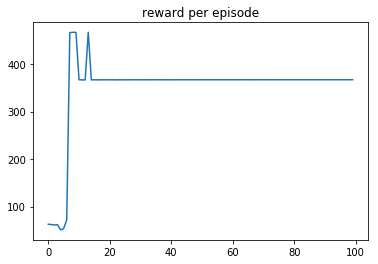

average reward over the last 10 episodes: 367.0


In [8]:
reward_all = results['reward_all'] # numpy array, shape (num_ep, max_t)
plt.plot(np.nansum(reward_all, axis=1))
plt.title("reward per episode")
plt.show()
print("average reward over the last 10 episodes: {:.1f}".format(np.nansum(reward_all, axis=1)[-10:].mean()))

## plot training results: trajectory

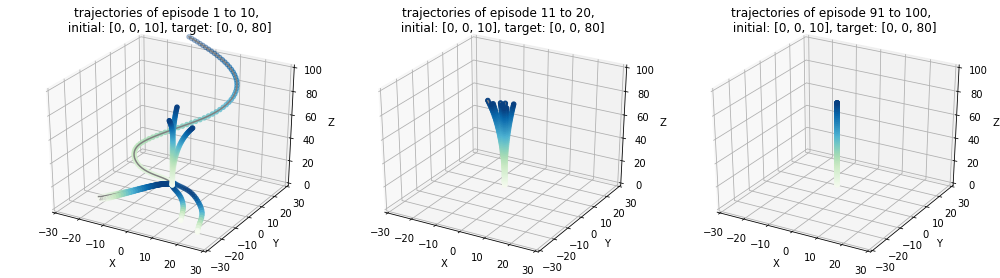

In [9]:
pos_all = results['pos_all']
num_ep = args['max_episodes']
ep_to_plot_list = [np.arange(0, 10), np.arange(10, 20), np.arange(num_ep-10, num_ep)]

fig = plt.figure(figsize=(14, 4))
for ii, ep_to_plot in enumerate(ep_to_plot_list):
    ax = plt.subplot(1, len(ep_to_plot_list), ii+1, projection='3d')
    plot_trajectory(task, ep_to_plot, pos_all, xmax=30, ymax=30, zmin=0, zmax=100, ax=ax)
plt.tight_layout()

## Question 4: discussion 
Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- The hardest part is parameter tuning for the DDPG agent. There are a huge number of hyper parameters, especially when deep neural networks are involved. I first implemented the agent following the DDPG paper, using all suggested parameter values. I then tested the agent on OpenAI Gym `Pendulum` and `Continuous Mountain Car` environments. It worked well on both environments using the original parameters. It still worked well after I downsized my actor and critic neural network models from (400, 300) to (32, 64). Finally I tested the agent on the quadcopter, but it didn't seem to learn. After some tedious tuning, it turns out that the soft target update parameter $\tau$ was the problem. The suggested value of $\tau=0.001$ in the origial DDPG paper does not work, while $\tau=0.1$ works well for the quadcopter.

- Specifying a task and designing the corresponding reward function is also not easy. But there are some guidelines for designing good reward functions as I mentioned above in Question 1. And if a task is too complex to design a reward for, we can always break it down into several smaller and simpler tasks. 

- Some findings: 
  - My reward function actually teaches the quadcopter to "move vertically (ascend or descend)". But the agent needs to be trained separately for "ascend" and "descend", i.e., trained with a higher target or a lower target. It seems that "ascend" is easier than "descend". For "ascend", learning is faster, and the final trajectory is perfectly vertical. While for "descend", learning is slower and less stable, and the final trajectory is not perfectly vertical.
- Some questions: 
  - **How to move in horizontal plane?** My reward function is based on the Euclidean distance to the target. If I check the success condition also based on the Euclidean distance, i.e., $|\Delta d| < 1$ instead of $|\Delta z| < 1$, I expect that the agent can learn to move in any direction. However if I set the initial position to [0, 0, 10], and the target position to [80, 0, 10], the agent does not learn to move horizontally. 
    - I tried adding angular velocities to the state, so the agent's state becomes $[x, y, z, \phi, \theta, \psi, v_x, v_y, v_z, \omega_\phi, \omega_\theta, \omega_\psi]$. It doesn't help.
    - Should we normalize the features in the state? For example, $[x, y, z]$ and $[\phi, \theta, \psi]$ can have very different scales. How to perform the normalization online during training and testing?
    - Here I've added OU noise to the action for exploration. Will it help to also apply epsilon-greedy to introduce some completely random actions?
  - **OU noise scale**: I plot the action values and the added OU noise values below. We can see that the action value is between 400 ~ 900, while the noise value is < 1. The added noise is so much smaller than the action, and it probably won't help anything for exploration. If I don't add any noise, the agent can still learn to "takeoff". If I increase the noise by a factor of 10, the learning performance is much worse. For a simple task like "takeoff", exploration noise probably won't matter. But in general how should we properly scale the exploration noise? Should we scale it to a range comparable with action values?

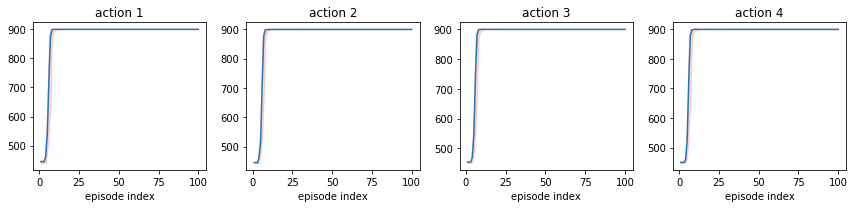

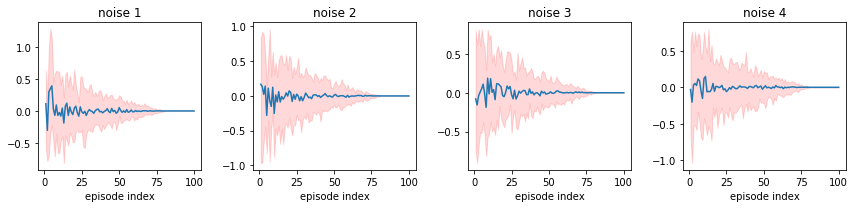

In [10]:
action_all, a_noise_all, a_clean_all = results['action_all'], results['a_noise_all'], results['a_clean_all']
plot_action(action_all, "action")
# plot_action(a_clean_all, "a_clean")
plot_action(a_noise_all, "noise")